# Medical Symptoms Checker - Model Training

This notebook trains and evaluates different ML models for symptom triage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sys
import os
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Add parent directory to path
sys.path.append('..')
from src.config import TRIAGE_LEVELS, MODELS_DIR

# Ensure models directory exists
MODELS_DIR.mkdir(exist_ok=True)

# Set random seed for reproducibility
np.random.seed(42)

## 1. Load Processed Data

In [2]:
# Load processed data
df = pd.read_csv('../data/processed_symptom_cases.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nTriage distribution:")
print(df['triage_name'].value_counts())

# Check for missing values
print(f"\nMissing values: {df.isnull().sum().sum()}")

Dataset shape: (30, 25)

Triage distribution:
triage_name
self-care     11
emergency     11
see_doctor     8
Name: count, dtype: int64

Missing values: 0


## 2. Prepare Features and Labels

In [3]:
# Define feature sets
symptom_features = [
    'fever', 'headache', 'cough', 'chest_pain', 'shortness_breath',
    'nausea', 'vomiting', 'diarrhea', 'fatigue', 'dizziness',
    'sore_throat', 'runny_nose', 'muscle_pain', 'abdominal_pain'
]

severity_features = ['pain_severity', 'duration_severity', 'intensity_severity']
demographic_features = ['age_group', 'gender']
other_features = ['symptom_count', 'text_length']

# Filter features that exist in the dataset
available_symptom_features = [f for f in symptom_features if f in df.columns]
available_severity_features = [f for f in severity_features if f in df.columns]
available_demographic_features = [f for f in demographic_features if f in df.columns]
available_other_features = [f for f in other_features if f in df.columns]

print(f"Available symptom features: {available_symptom_features}")
print(f"Available severity features: {available_severity_features}")
print(f"Available demographic features: {available_demographic_features}")
print(f"Available other features: {available_other_features}")

Available symptom features: ['fever', 'headache', 'cough', 'chest_pain', 'shortness_breath', 'nausea', 'vomiting', 'diarrhea', 'fatigue', 'dizziness', 'sore_throat', 'runny_nose', 'muscle_pain', 'abdominal_pain']
Available severity features: ['pain_severity', 'duration_severity', 'intensity_severity']
Available demographic features: ['age_group', 'gender']
Available other features: ['symptom_count', 'text_length']


In [4]:
# Prepare feature matrix and labels
feature_columns = (available_symptom_features + 
                  available_severity_features + 
                  available_other_features)

# Handle categorical features
df_encoded = df.copy()

# Encode age_group if available
if 'age_group' in df.columns:
    age_encoder = LabelEncoder()
    df_encoded['age_group_encoded'] = age_encoder.fit_transform(df['age_group'].fillna('unknown'))
    feature_columns.append('age_group_encoded')

# Encode gender if available
if 'gender' in df.columns:
    gender_encoder = LabelEncoder()
    df_encoded['gender_encoded'] = gender_encoder.fit_transform(df['gender'].fillna('unknown'))
    feature_columns.append('gender_encoded')

# Prepare final feature matrix
X_structured = df_encoded[feature_columns].fillna(0)
X_text = df['cleaned_text'] if 'cleaned_text' in df.columns else df['complaint_text']
y = df['triage_label']

print(f"Structured features shape: {X_structured.shape}")
print(f"Text features count: {len(X_text)}")
print(f"Labels shape: {y.shape}")
print(f"\nFeature columns: {feature_columns}")

Structured features shape: (30, 21)
Text features count: 30
Labels shape: (30,)

Feature columns: ['fever', 'headache', 'cough', 'chest_pain', 'shortness_breath', 'nausea', 'vomiting', 'diarrhea', 'fatigue', 'dizziness', 'sore_throat', 'runny_nose', 'muscle_pain', 'abdominal_pain', 'pain_severity', 'duration_severity', 'intensity_severity', 'symptom_count', 'text_length', 'age_group_encoded', 'gender_encoded']


## 3. Train Text-Based Models

In [5]:
# Split data for text-based models
X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_text_train)}")
print(f"Test set size: {len(X_text_test)}")
print(f"\nTraining set distribution:")
print(pd.Series(y_train).value_counts().sort_index())

Training set size: 24
Test set size: 6

Training set distribution:
triage_label
0    9
1    6
2    9
Name: count, dtype: int64


In [6]:
# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=1,
    max_df=0.95
)

# Fit and transform text data
X_text_train_tfidf = tfidf.fit_transform(X_text_train)
X_text_test_tfidf = tfidf.transform(X_text_test)

print(f"TF-IDF matrix shape: {X_text_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf.vocabulary_)}")

TF-IDF matrix shape: (24, 138)
Vocabulary size: 138


In [7]:
# Train text-based models
text_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(random_state=42, max_iter=2000)
}

text_results = {}

print("Training text-based models...")
print("=" * 50)

for name, model in text_models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_text_train_tfidf, y_train)
    
    # Make predictions
    y_pred = model.predict(X_text_test_tfidf)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_text_train_tfidf, y_train, cv=5)
    
    text_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print(f"Classification Report:")
    print(classification_report(y_test, y_pred, target_names=[TRIAGE_LEVELS[i] for i in sorted(TRIAGE_LEVELS.keys())]))

Training text-based models...

Training Logistic Regression...
Accuracy: 0.667
CV Score: 0.710 (+/- 0.183)
Classification Report:
              precision    recall  f1-score   support

   self-care       0.50      1.00      0.67         2
  see_doctor       0.00      0.00      0.00         2
   emergency       1.00      1.00      1.00         2

    accuracy                           0.67         6
   macro avg       0.50      0.67      0.56         6
weighted avg       0.50      0.67      0.56         6


Training Naive Bayes...
Accuracy: 0.667
CV Score: 0.670 (+/- 0.174)
Classification Report:
              precision    recall  f1-score   support

   self-care       0.50      1.00      0.67         2
  see_doctor       0.00      0.00      0.00         2
   emergency       1.00      1.00      1.00         2

    accuracy                           0.67         6
   macro avg       0.50      0.67      0.56         6
weighted avg       0.50      0.67      0.56         6


Training Linear

C:\Users\Ash09\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ash09\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ash09\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

## 4. Train Structured Feature Models

In [8]:
# Split structured data
X_struct_train, X_struct_test, y_struct_train, y_struct_test = train_test_split(
    X_structured, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_struct_train_scaled = scaler.fit_transform(X_struct_train)
X_struct_test_scaled = scaler.transform(X_struct_test)

print(f"Structured training set shape: {X_struct_train_scaled.shape}")

Structured training set shape: (24, 21)


In [9]:
# Train structured feature models
struct_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression (Structured)': LogisticRegression(random_state=42, max_iter=1000)
}

struct_results = {}

print("Training structured feature models...")
print("=" * 50)

for name, model in struct_models.items():
    print(f"\nTraining {name}...")
    
    # Use scaled features for logistic regression, original for random forest
    if 'Logistic' in name:
        X_train_use = X_struct_train_scaled
        X_test_use = X_struct_test_scaled
    else:
        X_train_use = X_struct_train
        X_test_use = X_struct_test
    
    # Train model
    model.fit(X_train_use, y_struct_train)
    
    # Make predictions
    y_pred = model.predict(X_test_use)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_struct_test, y_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_use, y_struct_train, cv=5)
    
    struct_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print(f"Classification Report:")
    print(classification_report(y_struct_test, y_pred, target_names=[TRIAGE_LEVELS[i] for i in sorted(TRIAGE_LEVELS.keys())]))

Training structured feature models...

Training Random Forest...
Accuracy: 0.500
CV Score: 0.710 (+/- 0.183)
Classification Report:
              precision    recall  f1-score   support

   self-care       0.33      0.50      0.40         2
  see_doctor       0.00      0.00      0.00         2
   emergency       0.67      1.00      0.80         2

    accuracy                           0.50         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.33      0.50      0.40         6


Training Logistic Regression (Structured)...
Accuracy: 0.500
CV Score: 0.880 (+/- 0.320)
Classification Report:
              precision    recall  f1-score   support

   self-care       0.33      0.50      0.40         2
  see_doctor       0.00      0.00      0.00         2
   emergency       0.67      1.00      0.80         2

    accuracy                           0.50         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.33      0.50      0.40     

C:\Users\Ash09\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ash09\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ash09\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

## 5. Model Comparison and Selection

In [10]:
# Combine all results
all_results = {**text_results, **struct_results}

# Create comparison DataFrame
comparison_data = []
for name, result in all_results.items():
    comparison_data.append({
        'Model': name,
        'Test Accuracy': result['accuracy'],
        'CV Mean': result['cv_mean'],
        'CV Std': result['cv_std']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)

print("Model Comparison:")
print(comparison_df.to_string(index=False))

# Select best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_result = all_results[best_model_name]
best_model = best_model_result['model']

print(f"\nBest model: {best_model_name}")
print(f"Best accuracy: {best_model_result['accuracy']:.3f}")

Model Comparison:
                           Model  Test Accuracy  CV Mean   CV Std
             Logistic Regression       0.666667     0.71 0.091652
                     Naive Bayes       0.666667     0.67 0.087178
                      Linear SVM       0.666667     0.67 0.153623
                   Random Forest       0.500000     0.71 0.091652
Logistic Regression (Structured)       0.500000     0.88 0.160000

Best model: Logistic Regression
Best accuracy: 0.667


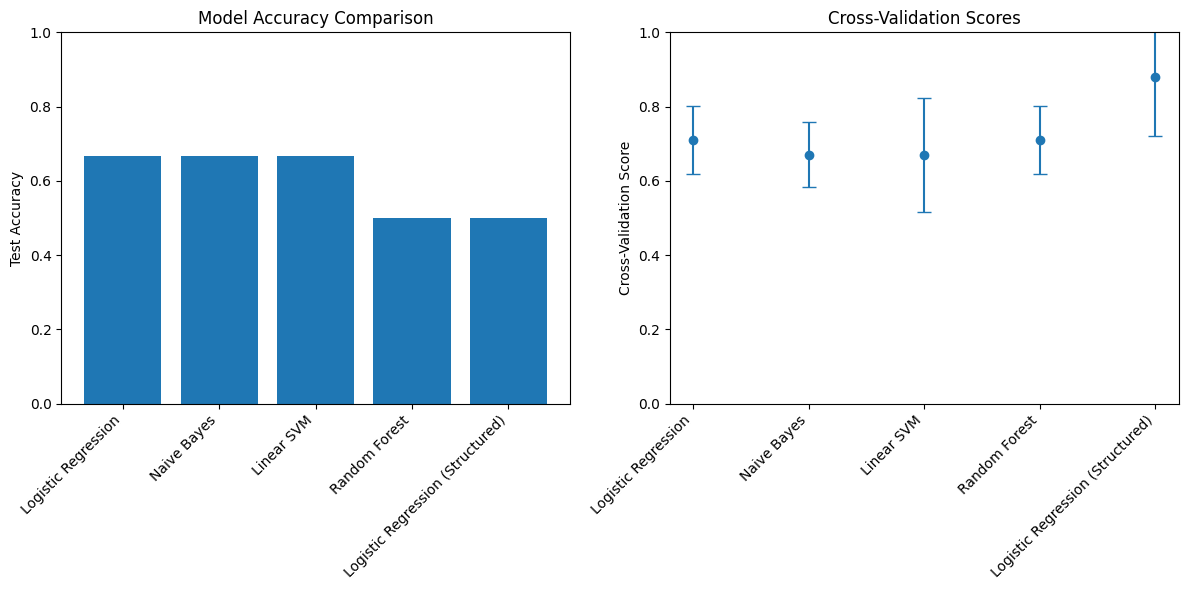

In [11]:
# Visualize model comparison
plt.figure(figsize=(12, 6))

# Plot accuracy comparison
plt.subplot(1, 2, 1)
plt.bar(range(len(comparison_df)), comparison_df['Test Accuracy'])
plt.xticks(range(len(comparison_df)), comparison_df['Model'], rotation=45, ha='right')
plt.ylabel('Test Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)

# Plot CV scores with error bars
plt.subplot(1, 2, 2)
plt.errorbar(range(len(comparison_df)), comparison_df['CV Mean'], 
             yerr=comparison_df['CV Std'], fmt='o', capsize=5)
plt.xticks(range(len(comparison_df)), comparison_df['Model'], rotation=45, ha='right')
plt.ylabel('Cross-Validation Score')
plt.title('Cross-Validation Scores')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

## 6. Detailed Analysis of Best Model

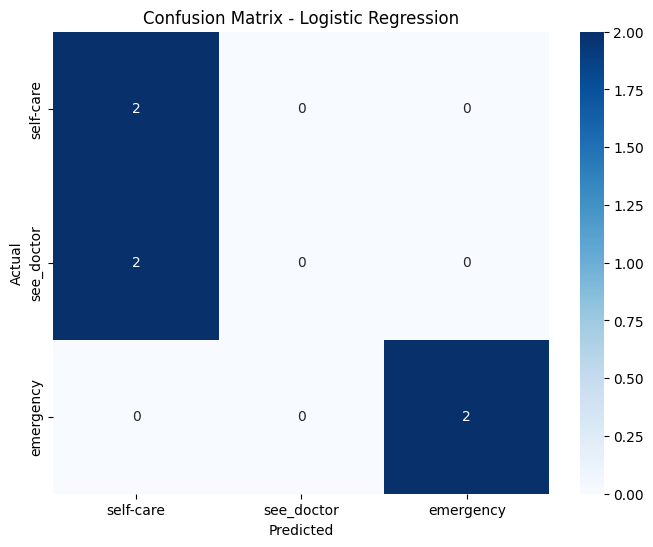


Detailed Classification Report for Logistic Regression:
              precision    recall  f1-score   support

   self-care       0.50      1.00      0.67         2
  see_doctor       0.00      0.00      0.00         2
   emergency       1.00      1.00      1.00         2

    accuracy                           0.67         6
   macro avg       0.50      0.67      0.56         6
weighted avg       0.50      0.67      0.56         6



C:\Users\Ash09\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ash09\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ash09\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [12]:
# Confusion matrix for best model
if 'text' in best_model_name.lower() or 'naive' in best_model_name.lower() or 'svm' in best_model_name.lower():
    y_pred_best = best_model_result['predictions']
    y_true_best = y_test
else:
    y_pred_best = best_model_result['predictions']
    y_true_best = y_struct_test

# Create confusion matrix
cm = confusion_matrix(y_true_best, y_pred_best)
labels = [TRIAGE_LEVELS[i] for i in sorted(TRIAGE_LEVELS.keys())]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Detailed classification report
print(f"\nDetailed Classification Report for {best_model_name}:")
print(classification_report(y_true_best, y_pred_best, target_names=labels))

In [13]:
# Feature importance (if available)
if hasattr(best_model, 'feature_importances_'):
    # For tree-based models
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 10 Feature Importances ({best_model_name}):")
    print(feature_importance.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(10)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 10 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

elif hasattr(best_model, 'coef_'):
    # For linear models
    if best_model_name in text_results:
        # Text-based model - show top TF-IDF features
        feature_names = tfidf.get_feature_names_out()
        coef = best_model.coef_
        
        for i, class_name in enumerate(labels):
            top_indices = np.argsort(np.abs(coef[i]))[-10:]
            top_features = [(feature_names[idx], coef[i][idx]) for idx in top_indices]
            print(f"\nTop features for {class_name}:")
            for feature, weight in sorted(top_features, key=lambda x: abs(x[1]), reverse=True):
                print(f"  {feature}: {weight:.3f}")
    else:
        # Structured feature model
        coef = best_model.coef_
        for i, class_name in enumerate(labels):
            feature_weights = pd.DataFrame({
                'feature': feature_columns,
                'weight': coef[i]
            }).sort_values('weight', key=abs, ascending=False)
            
            print(f"\nTop features for {class_name}:")
            print(feature_weights.head(10))


Top features for self-care:
  nose: 0.446
  pain: -0.411
  runny nose: 0.370
  runny: 0.370
  mild: 0.370
  severe: -0.344
  chest: -0.320
  fever: -0.308
  eating: 0.274
  chest pain: -0.267

Top features for see_doctor:
  aches: 0.370
  body: 0.370
  body aches: 0.370
  fever: 0.321
  vomiting: 0.303
  pain: 0.281
  pain breathing: 0.268
  breathing deeply: 0.268
  deeply: 0.268
  pain fever: 0.254

Top features for emergency:
  severe: 0.464
  severe headache: 0.416
  chest: 0.340
  nose: -0.256
  chest pain: 0.230
  mild: -0.213
  runny nose: -0.211
  runny: -0.211
  headache vomiting: 0.207
  body aches: -0.205


## 7. Save Best Model

In [14]:
# Save the best model and associated components
model_path = MODELS_DIR / "triage_model.joblib"
joblib.dump(best_model, model_path)
print(f"Best model saved to: {model_path}")

# Save vectorizer if it's a text-based model
if best_model_name in text_results:
    vectorizer_path = MODELS_DIR / "tfidf_vectorizer.joblib"
    joblib.dump(tfidf, vectorizer_path)
    print(f"TF-IDF vectorizer saved to: {vectorizer_path}")
else:
    # Save scaler for structured models
    scaler_path = MODELS_DIR / "feature_scaler.joblib"
    joblib.dump(scaler, scaler_path)
    print(f"Feature scaler saved to: {scaler_path}")

# Save label encoder
label_encoder = LabelEncoder()
label_encoder.fit(list(TRIAGE_LEVELS.values()))
label_encoder_path = MODELS_DIR / "label_encoder.joblib"
joblib.dump(label_encoder, label_encoder_path)
print(f"Label encoder saved to: {label_encoder_path}")

# Save model metadata
metadata = {
    'best_model': best_model_name,
    'accuracy': best_model_result['accuracy'],
    'cv_score': best_model_result['cv_mean'],
    'model_type': 'text' if best_model_name in text_results else 'structured',
    'feature_columns': feature_columns if best_model_name not in text_results else None,
    'training_samples': len(y_train),
    'test_samples': len(y_test)
}

import json
metadata_path = MODELS_DIR / "model_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Model metadata saved to: {metadata_path}")

print(f"\n✅ Model training completed!")
print(f"Best model: {best_model_name}")
print(f"Test accuracy: {best_model_result['accuracy']:.3f}")
print(f"Cross-validation score: {best_model_result['cv_mean']:.3f} ± {best_model_result['cv_std']:.3f}")

Best model saved to: C:\Users\Ash09\medica-advicer\backend\notebooks\..\models\triage_model.joblib
TF-IDF vectorizer saved to: C:\Users\Ash09\medica-advicer\backend\notebooks\..\models\tfidf_vectorizer.joblib
Label encoder saved to: C:\Users\Ash09\medica-advicer\backend\notebooks\..\models\label_encoder.joblib
Model metadata saved to: C:\Users\Ash09\medica-advicer\backend\notebooks\..\models\model_metadata.json

✅ Model training completed!
Best model: Logistic Regression
Test accuracy: 0.667
Cross-validation score: 0.710 ± 0.092
